In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target
# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/FloodNet_Object_detection/FloodNet_YOLOv8/train/images",
    ann_file="/content/drive/MyDrive/FloodNet_Object_detection/FloodNet_YOLOv8/train/train_annotations.json"
)


val_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/FloodNet_Object_detection/FloodNet_YOLOv8/val/images",
    ann_file="/content/drive/MyDrive/FloodNet_Object_detection/FloodNet_YOLOv8/val/val_annotations.json"
)

loading annotations into memory...
Done (t=3.23s)
creating index...
index created!
loading annotations into memory...
Done (t=2.27s)
creating index...
index created!


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import torchvision.transforms as T
from torchvision.datasets import CocoDetection
import torchvision.transforms.functional as F

# Define transformations
class CocoTransform:
    def __init__(self, size=(640, 640)):
        # Initialize the resize transformation to resize to 640x640
        self.resize = T.Resize(size)

    def __call__(self, image, target):
        # Resize the image
        image = self.resize(image)

        # Convert the PIL image to a tensor
        image = F.to_tensor(image)

        # Return the resized image and its target annotations
        return image, target

# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform(size=(640, 640))  # Apply resizing to 640x640
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/FloodNet_Object_detection/FloodNet_YOLOv8/train/images",
    ann_file="/content/drive/MyDrive/FloodNet_Object_detection/FloodNet_YOLOv8/train/anno_640.json"
)

val_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/FloodNet_Object_detection/FloodNet_YOLOv8/val/images",
    ann_file="/content/drive/MyDrive/FloodNet_Object_detection/FloodNet_YOLOv8/val/anno_640.json"
)


loading annotations into memory...
Done (t=3.30s)
creating index...
index created!
loading annotations into memory...
Done (t=1.00s)
creating index...
index created!


In [ ]:
image, target = train_dataset[0]

In [ ]:
image.shape

torch.Size([3, 3000, 4000])

In [ ]:
image.shape

torch.Size([3, 640, 640])

In [ ]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True ,num_workers= 8, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False ,num_workers= 4,collate_fn=lambda x: tuple(zip(*x)))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

# Define the model (same architecture as training)
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=10)  # Adjust num_classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:


# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

print(device)
# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)



cuda


In [ ]:
# Load checkpoint
checkpoint = torch.load('/content/drive/MyDrive/faster RCNN/checkpoint1.pth',map_location=torch.device('cuda'))

history = checkpoint['history']

# Restore model
model.load_state_dict(checkpoint['model_state_dict'])

# Restore optimizer and scheduler if you already defined them
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Get the last epoch
start_epoch = checkpoint['epoch'] + 1


In [ ]:
start_epoch

254

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from tqdm import tqdm  # Progress bar
import torch
from torchvision.ops import box_iou

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    total_images = 0
    train_losses = []
    classification_losses = []
    bbox_regression_losses = []
    iou_scores = []


    # Initialize tqdm progress bar
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch}", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        processed_targets = []
        valid_images = []

        # Process targets (filter invalid boxes)
        for i, target in enumerate(targets):
            # Extract valid boxes (w>0, h>0)
            boxes = [obj["bbox"] for obj in target if obj["bbox"][2] > 0 and obj["bbox"][3] > 0]

            # If there are any valid boxes:
            if boxes:
                # Convert to [x1, y1, x2, y2] format
                boxes = [[x, y, x + w, y + h] for x, y, w, h in boxes]

                # Create a processed target for this image
                processed_targets.append({
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor([obj["category_id"] for obj in target if obj["bbox"][2] > 0 and obj["bbox"][3] > 0], dtype=torch.int64).to(device),
                })

                # Append this image to the valid list
                valid_images.append(images[i])

            # If no valid boxes for this image:
            else:
                # Assign a default target with an empty box
                processed_targets.append({
                    "boxes": torch.zeros((0, 4), dtype=torch.float32).to(device),
                    "labels": torch.zeros(0, dtype=torch.int64).to(device)
                })
                # Still use the image, as the loss function can handle empty targets
                valid_images.append(images[i])


        # Skip iteration if no valid images after processing
        if not valid_images:
            continue

        images = valid_images  # Assign filtered list to images
        total_images += len(images)


        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        # Compute IoU (if model supports it)
        with torch.no_grad():
            # Switch model to evaluation mode for prediction
            model.eval()
            outputs = model(images)
            # Switch model back to training mode
            model.train()

            batch_iou = 0.0
            for output, target in zip(outputs, processed_targets):
                if "boxes" in output and len(output["boxes"]) > 0:
                    iou = box_iou(output["boxes"], target["boxes"])
                    batch_iou += iou.max(dim=1)[0].mean().item()  # Max IoU per prediction
            if len(images) > 0:
                total_iou += batch_iou / len(images)

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Inside the for-loop, after calculating the loss and before updating tqdm:
        current_lr = optimizer.param_groups[0]['lr']

        progress_bar.set_postfix({
            "Loss": f"{losses.item():.4f}",
            "Avg IoU": f"{(total_iou / (progress_bar.n + 1e-6)):.4f}",
            "Imgs": total_images,
            "LR": f"{current_lr:.6f}"  # << ADD LR here
        })


    # Epoch summary
    avg_loss = total_loss / len(data_loader)
    avg_iou = total_iou / len(data_loader)
    print(f"\nEpoch {epoch} Summary: Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f} | Images: {total_images} | LR: {current_lr:.6f}" )

    #model_path = f"/content/drive/MyDrive/fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
    #torch.save(model.state_dict(), model_path)


    #print(f"Model saved: {model_path}")

In [ ]:
from tqdm import tqdm
import torch
from torchvision.ops import box_iou

def train_one_epoch(model, optimizer, data_loader, device, epoch, history):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    total_images = 0

    # Initialize tqdm progress bar
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch}", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        processed_targets = []
        valid_images = []

        # Process targets (filter invalid boxes)
        for i, target in enumerate(targets):
            boxes = [obj["bbox"] for obj in target if obj["bbox"][2] > 0 and obj["bbox"][3] > 0]

            if boxes:
                boxes = [[x, y, x + w, y + h] for x, y, w, h in boxes]

                processed_targets.append({
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor([obj["category_id"] for obj in target if obj["bbox"][2] > 0 and obj["bbox"][3] > 0], dtype=torch.int64).to(device),
                })

                valid_images.append(images[i])

            else:
                processed_targets.append({
                    "boxes": torch.zeros((0, 4), dtype=torch.float32).to(device),
                    "labels": torch.zeros(0, dtype=torch.int64).to(device)
                })
                valid_images.append(images[i])

        if not valid_images:
            continue

        images = valid_images
        total_images += len(images)

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        # Compute IoU
        with torch.no_grad():
            model.eval()
            outputs = model(images)
            model.train()

            batch_iou = 0.0
            for output, target in zip(outputs, processed_targets):
                if "boxes" in output and len(output["boxes"]) > 0 and len(target["boxes"]) > 0:
                    iou = box_iou(output["boxes"], target["boxes"])
                    batch_iou += iou.max(dim=1)[0].mean().item()
            if len(images) > 0:
                total_iou += batch_iou / len(images)

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Update tqdm bar
        current_lr = optimizer.param_groups[0]['lr']
        progress_bar.set_postfix({
            "Loss": f"{losses.item():.4f}",
            "Avg IoU": f"{(total_iou / (progress_bar.n + 1e-6)):.4f}",
            "Imgs": total_images,
            "LR": f"{current_lr:.6f}"
        })

    # Calculate epoch averages
    avg_loss = total_loss / len(data_loader)
    avg_iou = total_iou / len(data_loader)

    print(f"\nEpoch {epoch} Summary: Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f} | Images: {total_images} | LR: {current_lr:.6f}")

    # Append to history
    history.append({
        'epoch': epoch,
        'loss': avg_loss,
        'iou': avg_iou,
        'lr': current_lr
    })






In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.

history = []  # << INITIALIZE here

for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")

    # Save the model's state dictionary after every epoch

    #model_path = f"/content/drive/MyDrive/fasterrcnn_resnet50_epoch_{epoch + 6}.pth"
    #torch.save(model.state_dict(), model_path)
    #print(f"Model saved: {model_path}")


Epoch 22 Summary: Loss: 1.2112 | IoU: 0.3391 | Images: 1445 | LR: 0.000100
Model saved



Epoch 23 Summary: Loss: 1.1611 | IoU: 0.3406 | Images: 1445 | LR: 0.000100
Model saved



Epoch 24 Summary: Loss: 1.1364 | IoU: 0.3404 | Images: 1445 | LR: 0.000100
Model saved



Epoch 25 Summary: Loss: 1.1356 | IoU: 0.3442 | Images: 1445 | LR: 0.000100
Model saved



Epoch 26 Summary: Loss: 1.1261 | IoU: 0.3413 | Images: 1445 | LR: 0.000100
Model saved



Epoch 27 Summary: Loss: 1.1143 | IoU: 0.3449 | Images: 1445 | LR: 0.000100
Model saved



Epoch 28 Summary: Loss: 1.1077 | IoU: 0.3431 | Images: 1445 | LR: 0.000100
Model saved


KeyboardInterrupt: 

In [ ]:
# Training loop
num_epochs = 280
for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),  # optional
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")

    # Save the model's state dictionary after every epoch

    #model_path = f"/content/drive/MyDrive/fasterrcnn_resnet50_epoch_{epoch + 6}.pth"
    #torch.save(model.state_dict(), model_path)
    #print(f"Model saved: {model_path}")


Epoch 29 Summary: Loss: 1.0997 | IoU: 0.3459 | Images: 1445 | LR: 0.000100
Model saved



Epoch 30 Summary: Loss: 1.0962 | IoU: 0.3437 | Images: 1445 | LR: 0.000100
Model saved



Epoch 31 Summary: Loss: 1.0837 | IoU: 0.3442 | Images: 1445 | LR: 0.000100
Model saved



Epoch 32 Summary: Loss: 1.0823 | IoU: 0.3455 | Images: 1445 | LR: 0.000090
Model saved



Epoch 33 Summary: Loss: 1.0741 | IoU: 0.3458 | Images: 1445 | LR: 0.000090
Model saved



Epoch 34 Summary: Loss: 1.0730 | IoU: 0.3474 | Images: 1445 | LR: 0.000090
Model saved



Epoch 35 Summary: Loss: 1.0642 | IoU: 0.3464 | Images: 1445 | LR: 0.000090
Model saved



Epoch 36 Summary: Loss: 1.0570 | IoU: 0.3461 | Images: 1445 | LR: 0.000090
Model saved



Epoch 37 Summary: Loss: 1.0560 | IoU: 0.3491 | Images: 1445 | LR: 0.000090
Model saved



Epoch 38 Summary: Loss: 1.0525 | IoU: 0.3477 | Images: 1445 | LR: 0.000090
Model saved



Epoch 39 Summary: Loss: 1.0450 | IoU: 0.3478 | Images: 1445 | LR: 0.000090
Model saved



Epoch 40 Summary: Loss: 1.0455 | IoU: 0.3521 | Images: 1445 | LR: 0.000090
Model saved


Epoch 41:   9%|▉         | 8/91 [01:16<08:43,  6.31s/it, Loss=1.2016, Avg IoU=0.3906, Imgs=128, LR=0.000090]

In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.

# history = new_h.copy() # << INITIALIZE here

for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")



Epoch 41 Summary: Loss: 1.0385 | IoU: 0.3478 | Images: 1445 | LR: 0.000090
Model saved



Epoch 42 Summary: Loss: 1.0368 | IoU: 0.3502 | Images: 1445 | LR: 0.000081
Model saved



Epoch 43 Summary: Loss: 1.0311 | IoU: 0.3522 | Images: 1445 | LR: 0.000081
Model saved



Epoch 44 Summary: Loss: 1.0284 | IoU: 0.3510 | Images: 1445 | LR: 0.000081
Model saved



Epoch 45 Summary: Loss: 1.0262 | IoU: 0.3531 | Images: 1445 | LR: 0.000081
Model saved



Epoch 46 Summary: Loss: 1.0174 | IoU: 0.3513 | Images: 1445 | LR: 0.000081
Model saved



Epoch 47 Summary: Loss: 1.0197 | IoU: 0.3524 | Images: 1445 | LR: 0.000081
Model saved



Epoch 48 Summary: Loss: 1.0122 | IoU: 0.3532 | Images: 1445 | LR: 0.000081
Model saved



Epoch 49 Summary: Loss: 1.0071 | IoU: 0.3512 | Images: 1445 | LR: 0.000081
Model saved



Epoch 50 Summary: Loss: 1.0076 | IoU: 0.3555 | Images: 1445 | LR: 0.000081
Model saved



Epoch 51 Summary: Loss: 1.0053 | IoU: 0.3525 | Images: 1445 | LR: 0.000081
Model saved



Epoch 52 Summary: Loss: 1.0002 | IoU: 0.3544 | Images: 1445 | LR: 0.000073
Model saved


Epoch 53:  51%|█████     | 46/91 [03:58<03:12,  4.29s/it, Loss=0.8470, Avg IoU=0.3591, Imgs=736, LR=0.000073]

In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.

history = new_h.copy() # << INITIALIZE here

for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")



Epoch 53 Summary: Loss: 0.9966 | IoU: 0.3547 | Images: 1445 | LR: 0.000073
Model saved



Epoch 54 Summary: Loss: 0.9937 | IoU: 0.3547 | Images: 1445 | LR: 0.000073
Model saved



Epoch 55 Summary: Loss: 0.9923 | IoU: 0.3544 | Images: 1445 | LR: 0.000073
Model saved



Epoch 56 Summary: Loss: 0.9883 | IoU: 0.3561 | Images: 1445 | LR: 0.000073
Model saved



Epoch 57 Summary: Loss: 0.9911 | IoU: 0.3546 | Images: 1445 | LR: 0.000073
Model saved



Epoch 58 Summary: Loss: 0.9882 | IoU: 0.3571 | Images: 1445 | LR: 0.000073
Model saved



Epoch 59 Summary: Loss: 0.9819 | IoU: 0.3555 | Images: 1445 | LR: 0.000073
Model saved



Epoch 60 Summary: Loss: 0.9764 | IoU: 0.3573 | Images: 1445 | LR: 0.000073
Model saved



Epoch 61 Summary: Loss: 0.9779 | IoU: 0.3578 | Images: 1445 | LR: 0.000073
Model saved



Epoch 62 Summary: Loss: 0.9767 | IoU: 0.3571 | Images: 1445 | LR: 0.000066
Model saved



Epoch 63 Summary: Loss: 0.9713 | IoU: 0.3548 | Images: 1445 | LR: 0.000066
Model saved



Epoch 64 Summary: Loss: 0.9660 | IoU: 0.3572 | Images: 1445 | LR: 0.000066
Model saved



Epoch 65 Summary: Loss: 0.9683 | IoU: 0.3574 | Images: 1445 | LR: 0.000066
Model saved


Epoch 66:  74%|███████▎  | 67/91 [05:19<01:41,  4.23s/it, Loss=0.7741, Avg IoU=0.3662, Imgs=1072, LR=0.000066]

In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.


for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")



Epoch 66 Summary: Loss: 0.9653 | IoU: 0.3591 | Images: 1445 | LR: 0.000066
Model saved



Epoch 67 Summary: Loss: 0.9646 | IoU: 0.3583 | Images: 1445 | LR: 0.000066
Model saved



Epoch 68 Summary: Loss: 0.9629 | IoU: 0.3585 | Images: 1445 | LR: 0.000066
Model saved



Epoch 69 Summary: Loss: 0.9627 | IoU: 0.3594 | Images: 1445 | LR: 0.000066
Model saved



Epoch 70 Summary: Loss: 0.9572 | IoU: 0.3582 | Images: 1445 | LR: 0.000066
Model saved



Epoch 71 Summary: Loss: 0.9536 | IoU: 0.3589 | Images: 1445 | LR: 0.000066
Model saved



Epoch 72 Summary: Loss: 0.9550 | IoU: 0.3592 | Images: 1445 | LR: 0.000059
Model saved



Epoch 73 Summary: Loss: 0.9482 | IoU: 0.3599 | Images: 1445 | LR: 0.000059
Model saved



Epoch 74 Summary: Loss: 0.9433 | IoU: 0.3589 | Images: 1445 | LR: 0.000059
Model saved



Epoch 75 Summary: Loss: 0.9429 | IoU: 0.3607 | Images: 1445 | LR: 0.000059
Model saved



Epoch 76 Summary: Loss: 0.9421 | IoU: 0.3603 | Images: 1445 | LR: 0.000059
Model saved



Epoch 77 Summary: Loss: 0.9436 | IoU: 0.3612 | Images: 1445 | LR: 0.000059
Model saved



Epoch 78 Summary: Loss: 0.9502 | IoU: 0.3619 | Images: 1445 | LR: 0.000059
Model saved



Epoch 79 Summary: Loss: 0.9423 | IoU: 0.3608 | Images: 1445 | LR: 0.000059
Model saved



Epoch 80 Summary: Loss: 0.9398 | IoU: 0.3614 | Images: 1445 | LR: 0.000059
Model saved



Epoch 81 Summary: Loss: 0.9385 | IoU: 0.3620 | Images: 1445 | LR: 0.000059
Model saved



Epoch 82 Summary: Loss: 0.9319 | IoU: 0.3622 | Images: 1445 | LR: 0.000053
Model saved



Epoch 83 Summary: Loss: 0.9316 | IoU: 0.3617 | Images: 1445 | LR: 0.000053
Model saved



Epoch 84 Summary: Loss: 0.9306 | IoU: 0.3625 | Images: 1445 | LR: 0.000053
Model saved



Epoch 85 Summary: Loss: 0.9289 | IoU: 0.3621 | Images: 1445 | LR: 0.000053
Model saved



Epoch 86 Summary: Loss: 0.9252 | IoU: 0.3619 | Images: 1445 | LR: 0.000053
Model saved



Epoch 87 Summary: Loss: 0.9290 | IoU: 0.3634 | Images: 1445 | LR: 0.000053
Model saved



Epoch 88 Summary: Loss: 0.9240 | IoU: 0.3610 | Images: 1445 | LR: 0.000053
Model saved



Epoch 89 Summary: Loss: 0.9254 | IoU: 0.3632 | Images: 1445 | LR: 0.000053
Model saved



Epoch 90 Summary: Loss: 0.9236 | IoU: 0.3626 | Images: 1445 | LR: 0.000053
Model saved



Epoch 91 Summary: Loss: 0.9219 | IoU: 0.3628 | Images: 1445 | LR: 0.000053
Model saved


Epoch 92:   8%|▊         | 7/91 [01:06<08:49,  6.30s/it, Loss=1.0970, Avg IoU=0.4308, Imgs=112, LR=0.000048]

In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.


for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")



Epoch 92 Summary: Loss: 0.9181 | IoU: 0.3635 | Images: 1445 | LR: 0.000048
Model saved



Epoch 93 Summary: Loss: 0.9158 | IoU: 0.3637 | Images: 1445 | LR: 0.000048
Model saved



Epoch 94 Summary: Loss: 0.9148 | IoU: 0.3640 | Images: 1445 | LR: 0.000048
Model saved



Epoch 95 Summary: Loss: 0.9122 | IoU: 0.3634 | Images: 1445 | LR: 0.000048
Model saved



Epoch 96 Summary: Loss: 0.9098 | IoU: 0.3648 | Images: 1445 | LR: 0.000048
Model saved



Epoch 97 Summary: Loss: 0.9112 | IoU: 0.3646 | Images: 1445 | LR: 0.000048
Model saved



Epoch 98 Summary: Loss: 0.9125 | IoU: 0.3669 | Images: 1445 | LR: 0.000048
Model saved



Epoch 99 Summary: Loss: 0.9106 | IoU: 0.3656 | Images: 1445 | LR: 0.000048
Model saved



Epoch 100 Summary: Loss: 0.9077 | IoU: 0.3650 | Images: 1445 | LR: 0.000048
Model saved



Epoch 101 Summary: Loss: 0.9093 | IoU: 0.3641 | Images: 1445 | LR: 0.000048
Model saved


Epoch 102:  63%|██████▎   | 57/91 [04:53<02:32,  4.50s/it, Loss=1.0012, Avg IoU=0.3721, Imgs=912, LR=0.000043]

In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.


for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")



Epoch 104 Summary: Loss: 0.9008 | IoU: 0.3668 | Images: 1445 | LR: 0.000043
Model saved



Epoch 105 Summary: Loss: 0.9008 | IoU: 0.3645 | Images: 1445 | LR: 0.000043
Model saved



Epoch 106 Summary: Loss: 0.8974 | IoU: 0.3652 | Images: 1445 | LR: 0.000043
Model saved



Epoch 107 Summary: Loss: 0.8976 | IoU: 0.3670 | Images: 1445 | LR: 0.000043
Model saved



Epoch 108 Summary: Loss: 0.8908 | IoU: 0.3655 | Images: 1445 | LR: 0.000043
Model saved



Epoch 109 Summary: Loss: 0.8908 | IoU: 0.3675 | Images: 1445 | LR: 0.000043
Model saved



Epoch 110 Summary: Loss: 0.8961 | IoU: 0.3672 | Images: 1445 | LR: 0.000043
Model saved



Epoch 111 Summary: Loss: 0.8902 | IoU: 0.3669 | Images: 1445 | LR: 0.000043
Model saved



Epoch 112 Summary: Loss: 0.8914 | IoU: 0.3664 | Images: 1445 | LR: 0.000039
Model saved



Epoch 113 Summary: Loss: 0.8905 | IoU: 0.3668 | Images: 1445 | LR: 0.000039
Model saved



Epoch 114 Summary: Loss: 0.8884 | IoU: 0.3694 | Images: 1445 | LR: 0.000039
Model saved



Epoch 115 Summary: Loss: 0.8893 | IoU: 0.3660 | Images: 1445 | LR: 0.000039
Model saved



Epoch 116 Summary: Loss: 0.8861 | IoU: 0.3677 | Images: 1445 | LR: 0.000039
Model saved



Epoch 117 Summary: Loss: 0.8894 | IoU: 0.3691 | Images: 1445 | LR: 0.000039
Model saved



Epoch 118 Summary: Loss: 0.8843 | IoU: 0.3679 | Images: 1445 | LR: 0.000039
Model saved



Epoch 119 Summary: Loss: 0.8817 | IoU: 0.3689 | Images: 1445 | LR: 0.000039
Model saved



Epoch 120 Summary: Loss: 0.8841 | IoU: 0.3691 | Images: 1445 | LR: 0.000039
Model saved



Epoch 121 Summary: Loss: 0.8847 | IoU: 0.3675 | Images: 1445 | LR: 0.000039
Model saved



Epoch 122 Summary: Loss: 0.8807 | IoU: 0.3695 | Images: 1445 | LR: 0.000035
Model saved



Epoch 123 Summary: Loss: 0.8760 | IoU: 0.3692 | Images: 1445 | LR: 0.000035
Model saved



Epoch 124 Summary: Loss: 0.8769 | IoU: 0.3684 | Images: 1445 | LR: 0.000035
Model saved



Epoch 125 Summary: Loss: 0.8785 | IoU: 0.3703 | Images: 1445 | LR: 0.000035
Model saved



Epoch 126 Summary: Loss: 0.8772 | IoU: 0.3690 | Images: 1445 | LR: 0.000035
Model saved



Epoch 127 Summary: Loss: 0.8706 | IoU: 0.3707 | Images: 1445 | LR: 0.000035
Model saved


Epoch 128:  66%|██████▌   | 60/91 [04:51<02:11,  4.24s/it, Loss=0.7242, Avg IoU=0.3790, Imgs=960, LR=0.000035]

In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.


for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")



Epoch 128 Summary: Loss: 0.8768 | IoU: 0.3701 | Images: 1445 | LR: 0.000035
Model saved



Epoch 129 Summary: Loss: 0.8781 | IoU: 0.3709 | Images: 1445 | LR: 0.000035
Model saved



Epoch 130 Summary: Loss: 0.8722 | IoU: 0.3701 | Images: 1445 | LR: 0.000035
Model saved



Epoch 131 Summary: Loss: 0.8751 | IoU: 0.3696 | Images: 1445 | LR: 0.000035
Model saved



Epoch 132 Summary: Loss: 0.8753 | IoU: 0.3711 | Images: 1445 | LR: 0.000031
Model saved



Epoch 133 Summary: Loss: 0.8658 | IoU: 0.3704 | Images: 1445 | LR: 0.000031
Model saved



Epoch 134 Summary: Loss: 0.8651 | IoU: 0.3702 | Images: 1445 | LR: 0.000031
Model saved



Epoch 135 Summary: Loss: 0.8714 | IoU: 0.3718 | Images: 1445 | LR: 0.000031
Model saved



Epoch 136 Summary: Loss: 0.8686 | IoU: 0.3702 | Images: 1445 | LR: 0.000031
Model saved



Epoch 137 Summary: Loss: 0.8668 | IoU: 0.3708 | Images: 1445 | LR: 0.000031
Model saved



Epoch 138 Summary: Loss: 0.8669 | IoU: 0.3726 | Images: 1445 | LR: 0.000031
Model saved



Epoch 139 Summary: Loss: 0.8680 | IoU: 0.3709 | Images: 1445 | LR: 0.000031
Model saved



Epoch 140 Summary: Loss: 0.8630 | IoU: 0.3714 | Images: 1445 | LR: 0.000031
Model saved



Epoch 141 Summary: Loss: 0.8663 | IoU: 0.3720 | Images: 1445 | LR: 0.000031
Model saved



Epoch 142 Summary: Loss: 0.8650 | IoU: 0.3740 | Images: 1445 | LR: 0.000028
Model saved



Epoch 143 Summary: Loss: 0.8654 | IoU: 0.3733 | Images: 1445 | LR: 0.000028
Model saved



Epoch 144 Summary: Loss: 0.8645 | IoU: 0.3731 | Images: 1445 | LR: 0.000028
Model saved



Epoch 145 Summary: Loss: 0.8574 | IoU: 0.3740 | Images: 1445 | LR: 0.000028
Model saved



Epoch 146 Summary: Loss: 0.8688 | IoU: 0.3732 | Images: 1445 | LR: 0.000028
Model saved



Epoch 147 Summary: Loss: 0.8604 | IoU: 0.3724 | Images: 1445 | LR: 0.000028
Model saved



Epoch 148 Summary: Loss: 0.8618 | IoU: 0.3750 | Images: 1445 | LR: 0.000028
Model saved



Epoch 149 Summary: Loss: 0.8599 | IoU: 0.3731 | Images: 1445 | LR: 0.000028
Model saved


KeyboardInterrupt: 

In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.


for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")



Epoch 150 Summary: Loss: 0.8561 | IoU: 0.3719 | Images: 1445 | LR: 0.000028
Model saved



Epoch 151 Summary: Loss: 0.8547 | IoU: 0.3731 | Images: 1445 | LR: 0.000028
Model saved



Epoch 152 Summary: Loss: 0.8565 | IoU: 0.3743 | Images: 1445 | LR: 0.000025
Model saved



Epoch 153 Summary: Loss: 0.8586 | IoU: 0.3731 | Images: 1445 | LR: 0.000025
Model saved



Epoch 154 Summary: Loss: 0.8540 | IoU: 0.3741 | Images: 1445 | LR: 0.000025
Model saved



Epoch 155 Summary: Loss: 0.8500 | IoU: 0.3725 | Images: 1445 | LR: 0.000025
Model saved



Epoch 156 Summary: Loss: 0.8510 | IoU: 0.3747 | Images: 1445 | LR: 0.000025
Model saved



Epoch 157 Summary: Loss: 0.8577 | IoU: 0.3738 | Images: 1445 | LR: 0.000025
Model saved



Epoch 158 Summary: Loss: 0.8499 | IoU: 0.3730 | Images: 1445 | LR: 0.000025
Model saved



Epoch 159 Summary: Loss: 0.8490 | IoU: 0.3745 | Images: 1445 | LR: 0.000025
Model saved



Epoch 160 Summary: Loss: 0.8505 | IoU: 0.3749 | Images: 1445 | LR: 0.000025
Model saved



Epoch 161 Summary: Loss: 0.8521 | IoU: 0.3743 | Images: 1445 | LR: 0.000025
Model saved



Epoch 162 Summary: Loss: 0.8523 | IoU: 0.3755 | Images: 1445 | LR: 0.000023
Model saved



Epoch 163 Summary: Loss: 0.8503 | IoU: 0.3750 | Images: 1445 | LR: 0.000023
Model saved



Epoch 164 Summary: Loss: 0.8500 | IoU: 0.3773 | Images: 1445 | LR: 0.000023
Model saved



Epoch 165 Summary: Loss: 0.8510 | IoU: 0.3746 | Images: 1445 | LR: 0.000023
Model saved



Epoch 166 Summary: Loss: 0.8477 | IoU: 0.3758 | Images: 1445 | LR: 0.000023
Model saved



Epoch 167 Summary: Loss: 0.8475 | IoU: 0.3749 | Images: 1445 | LR: 0.000023
Model saved



Epoch 168 Summary: Loss: 0.8469 | IoU: 0.3764 | Images: 1445 | LR: 0.000023
Model saved



Epoch 169 Summary: Loss: 0.8509 | IoU: 0.3761 | Images: 1445 | LR: 0.000023
Model saved



Epoch 170 Summary: Loss: 0.8449 | IoU: 0.3752 | Images: 1445 | LR: 0.000023
Model saved


KeyboardInterrupt: 

In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.


for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")



Epoch 171 Summary: Loss: 0.8438 | IoU: 0.3765 | Images: 1445 | LR: 0.000023
Model saved



Epoch 172 Summary: Loss: 0.8463 | IoU: 0.3755 | Images: 1445 | LR: 0.000021
Model saved



Epoch 173 Summary: Loss: 0.8434 | IoU: 0.3759 | Images: 1445 | LR: 0.000021
Model saved



Epoch 174 Summary: Loss: 0.8408 | IoU: 0.3774 | Images: 1445 | LR: 0.000021
Model saved



Epoch 175 Summary: Loss: 0.8426 | IoU: 0.3746 | Images: 1445 | LR: 0.000021
Model saved


Epoch 176:  21%|██        | 19/91 [01:58<05:05,  4.24s/it, Loss=0.9158, Avg IoU=0.3988, Imgs=304, LR=0.000021]

In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.


for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")



Epoch 176 Summary: Loss: 0.8408 | IoU: 0.3751 | Images: 1445 | LR: 0.000021
Model saved



Epoch 177 Summary: Loss: 0.8460 | IoU: 0.3761 | Images: 1445 | LR: 0.000021
Model saved



Epoch 178 Summary: Loss: 0.8415 | IoU: 0.3766 | Images: 1445 | LR: 0.000021
Model saved



Epoch 179 Summary: Loss: 0.8426 | IoU: 0.3768 | Images: 1445 | LR: 0.000021
Model saved



Epoch 180 Summary: Loss: 0.8421 | IoU: 0.3773 | Images: 1445 | LR: 0.000021
Model saved



Epoch 181 Summary: Loss: 0.8360 | IoU: 0.3769 | Images: 1445 | LR: 0.000021
Model saved



Epoch 182 Summary: Loss: 0.8399 | IoU: 0.3762 | Images: 1445 | LR: 0.000019
Model saved



Epoch 183 Summary: Loss: 0.8398 | IoU: 0.3774 | Images: 1445 | LR: 0.000019
Model saved



Epoch 184 Summary: Loss: 0.8390 | IoU: 0.3778 | Images: 1445 | LR: 0.000019
Model saved



Epoch 185 Summary: Loss: 0.8362 | IoU: 0.3775 | Images: 1445 | LR: 0.000019
Model saved



Epoch 186 Summary: Loss: 0.8368 | IoU: 0.3773 | Images: 1445 | LR: 0.000019
Model saved



Epoch 187 Summary: Loss: 0.8401 | IoU: 0.3776 | Images: 1445 | LR: 0.000019
Model saved



Epoch 188 Summary: Loss: 0.8377 | IoU: 0.3765 | Images: 1445 | LR: 0.000019
Model saved


Epoch 189:  47%|████▋     | 43/91 [03:48<03:33,  4.46s/it, Loss=0.8833, Avg IoU=0.3897, Imgs=688, LR=0.000019]

In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.


for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")



Epoch 189 Summary: Loss: 0.8376 | IoU: 0.3780 | Images: 1445 | LR: 0.000019
Model saved



Epoch 190 Summary: Loss: 0.8344 | IoU: 0.3761 | Images: 1445 | LR: 0.000019
Model saved



Epoch 191 Summary: Loss: 0.8349 | IoU: 0.3773 | Images: 1445 | LR: 0.000019
Model saved



Epoch 192 Summary: Loss: 0.8363 | IoU: 0.3778 | Images: 1445 | LR: 0.000017
Model saved



Epoch 193 Summary: Loss: 0.8335 | IoU: 0.3771 | Images: 1445 | LR: 0.000017
Model saved


Epoch 194:  24%|██▍       | 22/91 [02:10<04:52,  4.24s/it, Loss=1.0330, Avg IoU=0.3940, Imgs=352, LR=0.000017]

In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.


for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    #lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")



Epoch 195 Summary: Loss: 0.8332 | IoU: 0.3778 | Images: 1445 | LR: 0.000017
Model saved



Epoch 196 Summary: Loss: 0.8333 | IoU: 0.3794 | Images: 1445 | LR: 0.000017
Model saved



Epoch 197 Summary: Loss: 0.8347 | IoU: 0.3774 | Images: 1445 | LR: 0.000017
Model saved



Epoch 198 Summary: Loss: 0.8343 | IoU: 0.3781 | Images: 1445 | LR: 0.000017
Model saved



Epoch 199 Summary: Loss: 0.8314 | IoU: 0.3777 | Images: 1445 | LR: 0.000017
Model saved



Epoch 200 Summary: Loss: 0.8297 | IoU: 0.3787 | Images: 1445 | LR: 0.000017
Model saved



Epoch 201 Summary: Loss: 0.8300 | IoU: 0.3775 | Images: 1445 | LR: 0.000017
Model saved



Epoch 202 Summary: Loss: 0.8289 | IoU: 0.3781 | Images: 1445 | LR: 0.000015
Model saved



Epoch 203 Summary: Loss: 0.8357 | IoU: 0.3787 | Images: 1445 | LR: 0.000015
Model saved



Epoch 204 Summary: Loss: 0.8319 | IoU: 0.3768 | Images: 1445 | LR: 0.000015
Model saved



Epoch 205 Summary: Loss: 0.8285 | IoU: 0.3785 | Images: 1445 | LR: 0.000015
Model saved



Epoch 206 Summary: Loss: 0.8273 | IoU: 0.3792 | Images: 1445 | LR: 0.000015
Model saved



Epoch 207 Summary: Loss: 0.8290 | IoU: 0.3791 | Images: 1445 | LR: 0.000015
Model saved



Epoch 208 Summary: Loss: 0.8282 | IoU: 0.3783 | Images: 1445 | LR: 0.000015
Model saved



Epoch 209 Summary: Loss: 0.8298 | IoU: 0.3777 | Images: 1445 | LR: 0.000015
Model saved



Epoch 210 Summary: Loss: 0.8269 | IoU: 0.3784 | Images: 1445 | LR: 0.000015
Model saved



Epoch 211 Summary: Loss: 0.8288 | IoU: 0.3788 | Images: 1445 | LR: 0.000015
Model saved



Epoch 212 Summary: Loss: 0.8279 | IoU: 0.3786 | Images: 1445 | LR: 0.000014
Model saved



Epoch 213 Summary: Loss: 0.8258 | IoU: 0.3790 | Images: 1445 | LR: 0.000014
Model saved



Epoch 214 Summary: Loss: 0.8278 | IoU: 0.3792 | Images: 1445 | LR: 0.000014
Model saved



Epoch 215 Summary: Loss: 0.8256 | IoU: 0.3787 | Images: 1445 | LR: 0.000014
Model saved



Epoch 216 Summary: Loss: 0.8261 | IoU: 0.3785 | Images: 1445 | LR: 0.000014
Model saved



Epoch 217 Summary: Loss: 0.8259 | IoU: 0.3783 | Images: 1445 | LR: 0.000014
Model saved



Epoch 218 Summary: Loss: 0.8240 | IoU: 0.3790 | Images: 1445 | LR: 0.000014
Model saved



Epoch 219 Summary: Loss: 0.8217 | IoU: 0.3794 | Images: 1445 | LR: 0.000014
Model saved



Epoch 220 Summary: Loss: 0.8254 | IoU: 0.3794 | Images: 1445 | LR: 0.000014
Model saved



Epoch 221 Summary: Loss: 0.8232 | IoU: 0.3792 | Images: 1445 | LR: 0.000014
Model saved



Epoch 222 Summary: Loss: 0.8221 | IoU: 0.3806 | Images: 1445 | LR: 0.000012
Model saved



Epoch 223 Summary: Loss: 0.8228 | IoU: 0.3784 | Images: 1445 | LR: 0.000012
Model saved


Epoch 224:  51%|█████     | 46/91 [03:56<03:15,  4.34s/it, Loss=0.7532, Avg IoU=0.3932, Imgs=736, LR=0.000012]

In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.


for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    #lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")



Epoch 224 Summary: Loss: 0.8243 | IoU: 0.3807 | Images: 1445 | LR: 0.000012
Model saved



Epoch 225 Summary: Loss: 0.8205 | IoU: 0.3780 | Images: 1445 | LR: 0.000012
Model saved



Epoch 226 Summary: Loss: 0.8241 | IoU: 0.3802 | Images: 1445 | LR: 0.000012
Model saved



Epoch 227 Summary: Loss: 0.8245 | IoU: 0.3786 | Images: 1445 | LR: 0.000012
Model saved



Epoch 228 Summary: Loss: 0.8254 | IoU: 0.3807 | Images: 1445 | LR: 0.000012
Model saved



Epoch 229 Summary: Loss: 0.8233 | IoU: 0.3806 | Images: 1445 | LR: 0.000012
Model saved



Epoch 230 Summary: Loss: 0.8227 | IoU: 0.3804 | Images: 1445 | LR: 0.000012
Model saved



Epoch 231 Summary: Loss: 0.8230 | IoU: 0.3803 | Images: 1445 | LR: 0.000012
Model saved



Epoch 232 Summary: Loss: 0.8200 | IoU: 0.3809 | Images: 1445 | LR: 0.000012
Model saved



Epoch 233 Summary: Loss: 0.8225 | IoU: 0.3786 | Images: 1445 | LR: 0.000012
Model saved



Epoch 234 Summary: Loss: 0.8218 | IoU: 0.3815 | Images: 1445 | LR: 0.000012
Model saved



Epoch 235 Summary: Loss: 0.8223 | IoU: 0.3810 | Images: 1445 | LR: 0.000012
Model saved



Epoch 236 Summary: Loss: 0.8205 | IoU: 0.3805 | Images: 1445 | LR: 0.000012
Model saved



Epoch 237 Summary: Loss: 0.8196 | IoU: 0.3812 | Images: 1445 | LR: 0.000012
Model saved



Epoch 238 Summary: Loss: 0.8210 | IoU: 0.3827 | Images: 1445 | LR: 0.000012
Model saved



Epoch 239 Summary: Loss: 0.8202 | IoU: 0.3804 | Images: 1445 | LR: 0.000012
Model saved



Epoch 240 Summary: Loss: 0.8160 | IoU: 0.3798 | Images: 1445 | LR: 0.000012
Model saved



Epoch 241 Summary: Loss: 0.8217 | IoU: 0.3825 | Images: 1445 | LR: 0.000012
Model saved



Epoch 242 Summary: Loss: 0.8186 | IoU: 0.3793 | Images: 1445 | LR: 0.000012
Model saved



Epoch 243 Summary: Loss: 0.8170 | IoU: 0.3803 | Images: 1445 | LR: 0.000012
Model saved



Epoch 244 Summary: Loss: 0.8187 | IoU: 0.3803 | Images: 1445 | LR: 0.000012
Model saved



Epoch 245 Summary: Loss: 0.8198 | IoU: 0.3810 | Images: 1445 | LR: 0.000012
Model saved



Epoch 246 Summary: Loss: 0.8166 | IoU: 0.3824 | Images: 1445 | LR: 0.000012
Model saved



Epoch 247 Summary: Loss: 0.8176 | IoU: 0.3803 | Images: 1445 | LR: 0.000012
Model saved



Epoch 248 Summary: Loss: 0.8185 | IoU: 0.3801 | Images: 1445 | LR: 0.000012
Model saved



Epoch 249 Summary: Loss: 0.8156 | IoU: 0.3794 | Images: 1445 | LR: 0.000012
Model saved



Epoch 250 Summary: Loss: 0.8156 | IoU: 0.3813 | Images: 1445 | LR: 0.000012
Model saved



Epoch 251 Summary: Loss: 0.8155 | IoU: 0.3815 | Images: 1445 | LR: 0.000012
Model saved



Epoch 252 Summary: Loss: 0.8181 | IoU: 0.3809 | Images: 1445 | LR: 0.000012
Model saved



Epoch 253 Summary: Loss: 0.8145 | IoU: 0.3800 | Images: 1445 | LR: 0.000012
Model saved


KeyboardInterrupt: 

In [ ]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.


for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
    lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")



Epoch 254 Summary: Loss: 0.8173 | IoU: 0.3824 | Images: 1445 | LR: 0.000012
Model saved



Epoch 255 Summary: Loss: 0.8146 | IoU: 0.3818 | Images: 1445 | LR: 0.000012
Model saved



Epoch 256 Summary: Loss: 0.8127 | IoU: 0.3807 | Images: 1445 | LR: 0.000012
Model saved



Epoch 257 Summary: Loss: 0.8159 | IoU: 0.3824 | Images: 1445 | LR: 0.000012
Model saved



Epoch 258 Summary: Loss: 0.8158 | IoU: 0.3803 | Images: 1445 | LR: 0.000012
Model saved



Epoch 259 Summary: Loss: 0.8156 | IoU: 0.3819 | Images: 1445 | LR: 0.000012
Model saved



Epoch 260 Summary: Loss: 0.8167 | IoU: 0.3815 | Images: 1445 | LR: 0.000012
Model saved



Epoch 261 Summary: Loss: 0.8124 | IoU: 0.3813 | Images: 1445 | LR: 0.000012
Model saved



Epoch 262 Summary: Loss: 0.8144 | IoU: 0.3825 | Images: 1445 | LR: 0.000011
Model saved



Epoch 263 Summary: Loss: 0.8132 | IoU: 0.3808 | Images: 1445 | LR: 0.000011
Model saved



Epoch 264 Summary: Loss: 0.8101 | IoU: 0.3830 | Images: 1445 | LR: 0.000011
Model saved



Epoch 265 Summary: Loss: 0.8154 | IoU: 0.3824 | Images: 1445 | LR: 0.000011
Model saved



Epoch 266 Summary: Loss: 0.8133 | IoU: 0.3812 | Images: 1445 | LR: 0.000011
Model saved



Epoch 267 Summary: Loss: 0.8143 | IoU: 0.3832 | Images: 1445 | LR: 0.000011
Model saved



Epoch 268 Summary: Loss: 0.8124 | IoU: 0.3814 | Images: 1445 | LR: 0.000011
Model saved



Epoch 269 Summary: Loss: 0.8121 | IoU: 0.3812 | Images: 1445 | LR: 0.000011
Model saved



Epoch 270 Summary: Loss: 0.8112 | IoU: 0.3822 | Images: 1445 | LR: 0.000011
Model saved



Epoch 271 Summary: Loss: 0.8115 | IoU: 0.3812 | Images: 1445 | LR: 0.000011
Model saved



Epoch 272 Summary: Loss: 0.8076 | IoU: 0.3824 | Images: 1445 | LR: 0.000010
Model saved



Epoch 273 Summary: Loss: 0.8116 | IoU: 0.3831 | Images: 1445 | LR: 0.000010
Model saved



Epoch 274 Summary: Loss: 0.8106 | IoU: 0.3823 | Images: 1445 | LR: 0.000010
Model saved



Epoch 275 Summary: Loss: 0.8123 | IoU: 0.3826 | Images: 1445 | LR: 0.000010
Model saved



Epoch 276 Summary: Loss: 0.8082 | IoU: 0.3830 | Images: 1445 | LR: 0.000010
Model saved



Epoch 277 Summary: Loss: 0.8101 | IoU: 0.3826 | Images: 1445 | LR: 0.000010
Model saved



Epoch 278 Summary: Loss: 0.8105 | IoU: 0.3827 | Images: 1445 | LR: 0.000010
Model saved



Epoch 279 Summary: Loss: 0.8150 | IoU: 0.3822 | Images: 1445 | LR: 0.000010
Model saved


In [16]:
# Training loop
num_epochs = 280
# 1. Initialize model, optimizer, data_loader, device, etc.


for epoch in range(start_epoch,num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch,history)
   # lr_scheduler.step()
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'history': history,
}, '/content/drive/MyDrive/faster RCNN/checkpoint1.pth')
    print(f"Model saved")


Epoch 254:   2%|▏         | 2/91 [00:33<22:16, 15.02s/it, Loss=0.7050, Avg IoU=0.7429, Imgs=32, LR=0.000010]Process Process-212:


KeyboardInterrupt: 

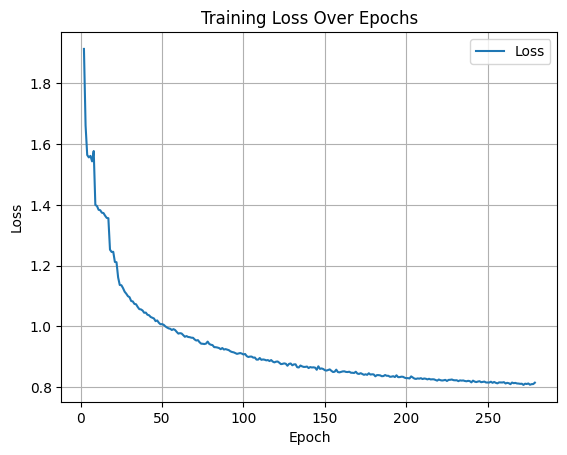

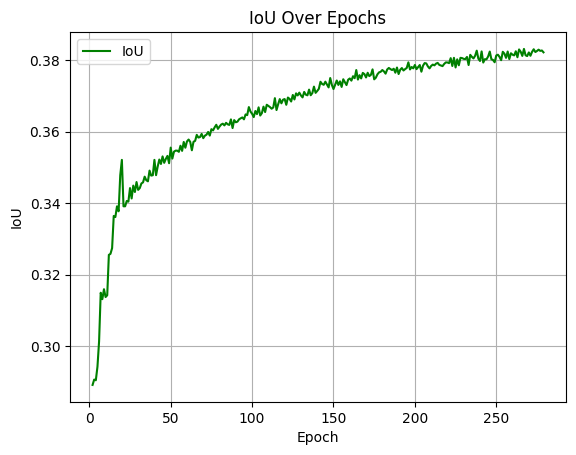

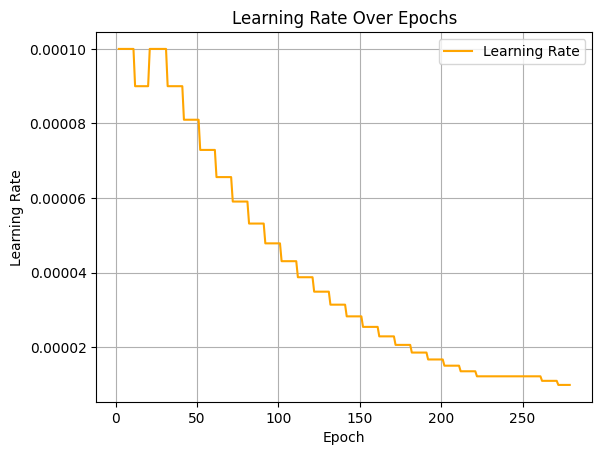

In [14]:
import torch
import matplotlib.pyplot as plt

# Load checkpoint
checkpoint = torch.load('/content/drive/MyDrive/faster RCNN/checkpoint1.pth', map_location='cuda')
history = checkpoint['history']

# Extract values
epochs = [h['epoch'] for h in history]
losses = [h['loss'] for h in history]
ious = [h['iou'] for h in history]
lrs = [h['lr'] for h in history]

# Plot Loss
plt.figure()
plt.plot(epochs, losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.legend()
plt.show()

# Plot IoU
plt.figure()
plt.plot(epochs, ious, label='IoU', color='green')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU Over Epochs')
plt.grid()
plt.legend()
plt.show()

# Plot Learning Rate (Optional)
plt.figure()
plt.plot(epochs, lrs, label='Learning Rate', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.grid()
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 129MB/s]


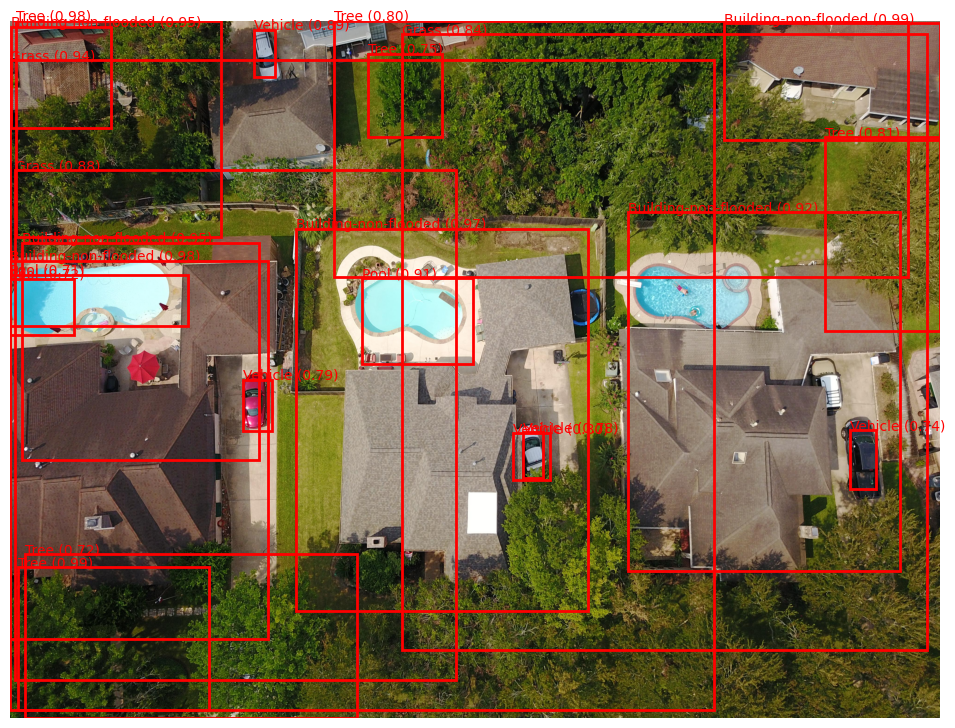

In [15]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# Initialize the model
num_classes = 10  # Background + chair + person + table

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Load the trained model
model = get_model(num_classes)
#model.load_state_dict(torch.load("/content/drive/MyDrive/faster RCNN/checkpoint1.pth"),map_location=torch.device('cpu'))

checkpoint = torch.load('/content/drive/MyDrive/faster RCNN/checkpoint1.pth',map_location=torch.device('cuda'))


# Restore model
model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)
model.eval()  # Set the model to evaluation mode


def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
   # image = image.resize((640, 640))  # Resize image to 640x640 pixels
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)



# Load the unseen image
image_path = "/content/drive/MyDrive/FloodNet_Object_detection/FloodNet_YOLOv8/test/images/10174.jpg"
image_tensor = prepare_image(image_path)

with torch.no_grad():  # Disable gradient computation for inference
    prediction = model(image_tensor)

# `prediction` contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)
COCO_CLASSES = {
   # 0: "Background",
    1: "Building-flooded",
    2: "Building-non-flooded",
    3: "Road-flooded",
    4: "Road-non-flooded",
    5: "Water",
    6: "Tree",
    7: "Vehicle",
    8: "Pool",
    9: "Grass"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

# Draw bounding boxes with the correct class names and increase image size
# def draw_boxes(image, prediction, fig_size=(10, 10)):
#     boxes = prediction[0]['boxes'].cpu().numpy()  # Get predicted bounding boxes
#     labels = prediction[0]['labels'].cpu().numpy()  # Get predicted labels
#     scores = prediction[0]['scores'].cpu().numpy()  # Get predicted scores

#     # Set a threshold for showing boxes (e.g., score > 0.5)
#     threshold = 0.8

#     # Set up the figure size to control the image size
#     plt.figure(figsize=fig_size)  # Adjust the figure size here

#     for box, label, score in zip(boxes, labels, scores):
#         if score > threshold and width >= 10 and height >= 10:
#             x_min, y_min, x_max, y_max = box
#             class_name = get_class_name(label)  # Get the class name
#             plt.imshow(image)  # Display the image
#             plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
#                                               linewidth=2, edgecolor='r', facecolor='none'))
#             plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='r')

#     plt.axis('off')  # Turn off axis
#     plt.show()
def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()  # Get predicted bounding boxes
    labels = prediction[0]['labels'].cpu().numpy()  # Get predicted labels
    scores = prediction[0]['scores'].cpu().numpy()  # Get predicted scores

    threshold = 0.7  # Confidence score threshold

    plt.figure(figsize=fig_size)
    plt.imshow(image)  # Display the image once

    for box, label, score in zip(boxes, labels, scores):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        # Filter by confidence score and minimum bbox size
        if score > threshold :#and width >= 150 and height >= 120:
            class_name = get_class_name(label)
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), width, height,
                                              linewidth=2, edgecolor='r', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='r')

    plt.axis('off')
    plt.show()

# Display the image with bounding boxes and correct labels
draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))  # Example of increased size

In [ ]:
!git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...
remote: Enumerating objects: 634315, done.
remote: Counting objects: 100% (376/376), done.
remote: Compressing objects: 100% (249/249), done.
remote: Total 634315 (delta 230), reused 128 (delta 127), pack-reused 633939 (from 3)
Receiving objects: 100% (634315/634315), 1.16 GiB | 26.00 MiB/s, done.
Resolving deltas: 100% (593358/593358), done.


In [ ]:
!git clone https://github.com/pytorch/vision.git


fatal: destination path 'vision' already exists and is not an empty directory.


In [ ]:
!mkdir -p /content/drive/MyDrive/fasterRCNN/detection
!cp -r vision/references/detection/* /content/drive/MyDrive/fasterRCNN/detection/


In [ ]:
!cp -r vision/references/detection /content/detection


In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from detection.engine import evaluate
from detection import utils
from detection.coco_utils import get_coco_api_from_dataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your Faster R-CNN model (pretrained=False if you have custom weights)
model = fasterrcnn_resnet50_fpn(num_classes=4)  # adjust num_classes as needed
model.load_state_dict(torch.load("your_model.pth", map_location=device))  # update with your model path
model.to(device)
model.eval()

# Load COCO-style dataset
dataset = CocoDetection(
    root="/content/drive/MyDrive/FloodNet_Object_detection/FloodNet_YOLOv8/val/images",
    annFile="/content/drive/MyDrive/FloodNet_Object_detection/FloodNet_YOLOv8/val/anno_640.json",
    transform=ToTensor()
)

# Wrap in DataLoader
data_loader = DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=utils.collate_fn
)

# Evaluate and print mAP
evaluate(model, data_loader, device=device)


ModuleNotFoundError: No module named 'utils'